# Example: Classification of Text with a Fully Connected Neural Network

This notebok presents an exmaple of text classification. The code can be found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by Francois Chollet.

In [323]:
import keras

# 3.5 Classifying newswires: a multi-class classification example

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [324]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [325]:
len(train_data)

8982

In [326]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [327]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [328]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [329]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [330]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [331]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [332]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [333]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [334]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [335]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [336]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [337]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 0s 10ms/step - loss: 2.7515 - accuracy: 0.5016 - val_loss: 1.8150 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 1.4659 - accuracy: 0.7110 - val_loss: 1.3084 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 1.0623 - accuracy: 0.7809 - val_loss: 1.1294 - val_accuracy: 0.7610
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 0.8325 - accuracy: 0.8215 - val_loss: 1.0313 - val_accuracy: 0.7970
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 0.6653 - accuracy: 0.8604 - val_loss: 0.9692 - val_accuracy: 0.8050
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 0.5336 - accuracy: 0.8900 - val_loss: 0.9321 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.4326 - accuracy: 0.9107 - val_loss: 0.9081 - val_accuracy: 0.8080
Epoch 8/20
16/16 [=

Let's display its loss and accuracy curves:

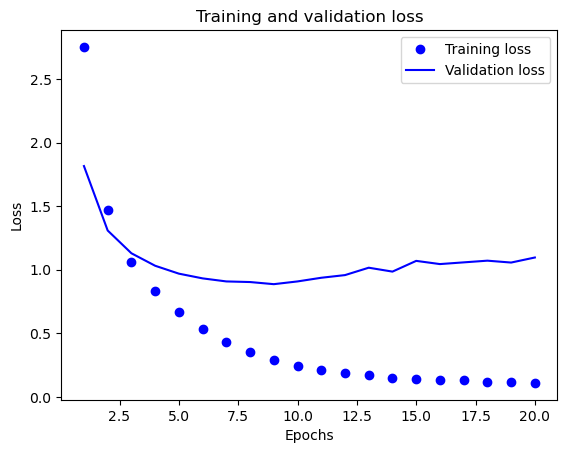

In [338]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

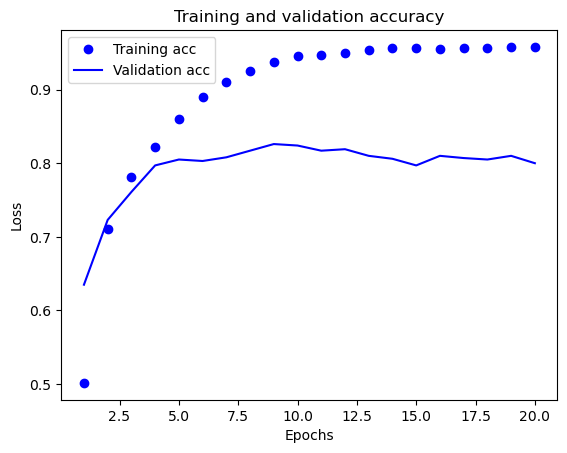

In [339]:
plt.clf()   # clear figure

# Solutions to P1 from example

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [340]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 0s 10ms/step - loss: 2.6506 - accuracy: 0.5306 - val_loss: 1.7231 - val_accuracy: 0.6360
Epoch 2/8
16/16 [==============================] - 0s 7ms/step - loss: 1.4083 - accuracy: 0.7085 - val_loss: 1.2735 - val_accuracy: 0.7140
Epoch 3/8
16/16 [==============================] - 0s 7ms/step - loss: 1.0344 - accuracy: 0.7801 - val_loss: 1.1077 - val_accuracy: 0.7590
Epoch 4/8
16/16 [==============================] - 0s 7ms/step - loss: 0.8207 - accuracy: 0.8254 - val_loss: 1.0181 - val_accuracy: 0.7770
Epoch 5/8
16/16 [==============================] - 0s 7ms/step - loss: 0.6513 - accuracy: 0.8622 - val_loss: 0.9695 - val_accuracy: 0.7870
Epoch 6/8
16/16 [==============================] - 0s 7ms/step - loss: 0.5237 - accuracy: 0.8898 - val_loss: 0.9127 - val_accuracy: 0.8060
Epoch 7/8
16/16 [==============================] - 0s 7ms/step - loss: 0.4193 - accuracy: 0.9128 - val_loss: 0.8960 - val_accuracy: 0.8110
Epoch 8/8
71/71 [=========

In [341]:
results

[0.9955973029136658, 0.7813891172409058]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [342]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18788958147818344

In [343]:
# Solutions to P2

In [344]:
# Add Dropout Layers and increase number of neurons in hidden layers
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))  # Add dropout to prevent overfitting
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Add another dropout layer
model.add(layers.Dense(46, activation='softmax'))

In [345]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,  # Increase epochs
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Epoch 1/30
16/16 [==============================] - 0s 14ms/step - loss: 2.5554 - accuracy: 0.4442 - val_loss: 1.5890 - val_accuracy: 0.6320
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 1.5741 - accuracy: 0.6377 - val_loss: 1.3284 - val_accuracy: 0.6910
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 1.3208 - accuracy: 0.6883 - val_loss: 1.1994 - val_accuracy: 0.7180
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 1.1626 - accuracy: 0.7246 - val_loss: 1.1150 - val_accuracy: 0.7510
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 1.0288 - accuracy: 0.7565 - val_loss: 1.0642 - val_accuracy: 0.7610
Epoch 6/30
16/16 [==============================] - 0s 11ms/step - loss: 0.9314 - accuracy: 0.7811 - val_loss: 1.0137 - val_accuracy: 0.7800
Epoch 7/30
16/16 [==============================] - 0s 11ms/step - loss: 0.8361 - accuracy: 0.8028 - val_loss: 0.9826 - val_accuracy: 0.7930
Epoch 8/30
16

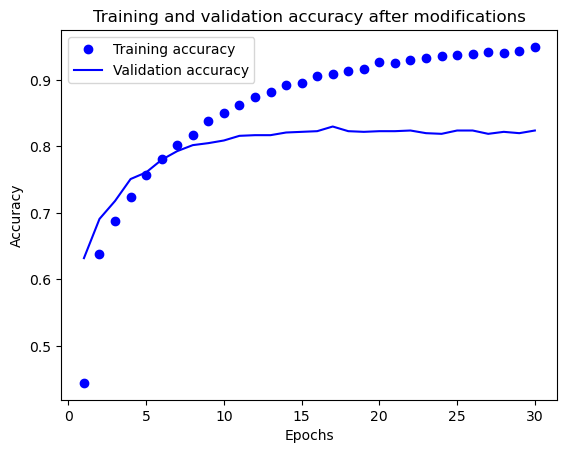

In [346]:
# Plotting the training and validation accuracy
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy after modifications')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [347]:
# Evaluate the model on the test data
results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 [==============================] - 0s 641us/step - loss: 1.4318 - accuracy: 0.7947


[1.431762456893921, 0.7947462201118469]

In [ ]:
# Solutions to P3

In [348]:
from keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adamax

# Function to build and compile the model with different optimizers
def build_and_compile_model(optimizer):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# List of optimizers to try
optimizers = {
    "RMSprop": RMSprop(learning_rate=0.0005),
    "Adam": Adam(learning_rate=0.0005),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "Adagrad": Adagrad(learning_rate=0.001),
    "AdaMax": Adamax(learning_rate=0.0005)
}

# Dictionary to store results
results_table = {}


Training with RMSprop optimizer...


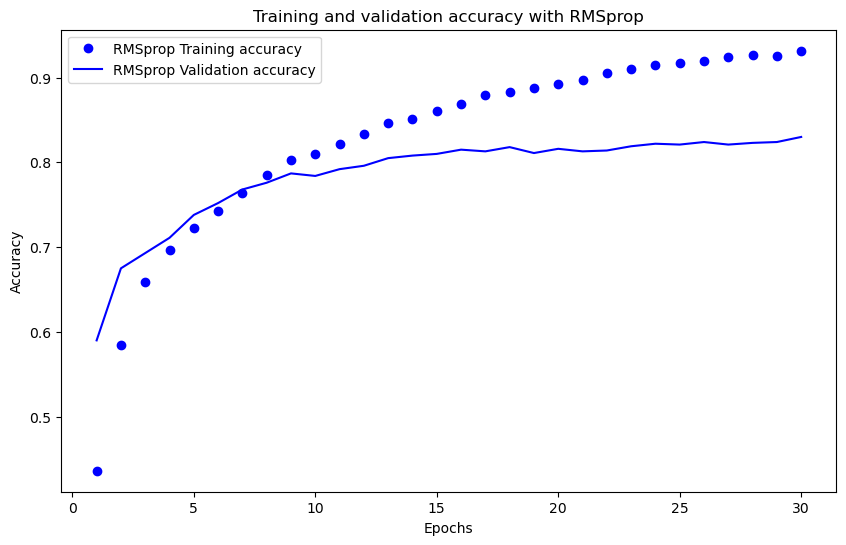

Training with Adam optimizer...


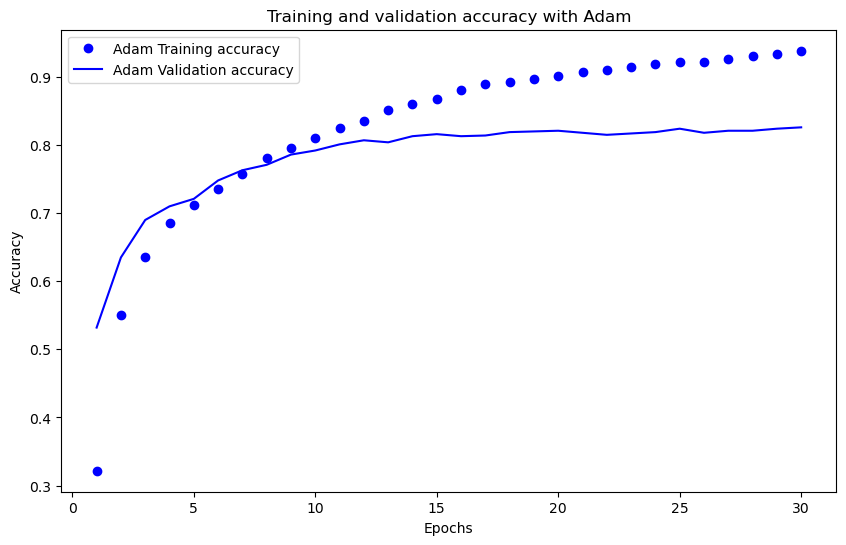

Training with SGD optimizer...


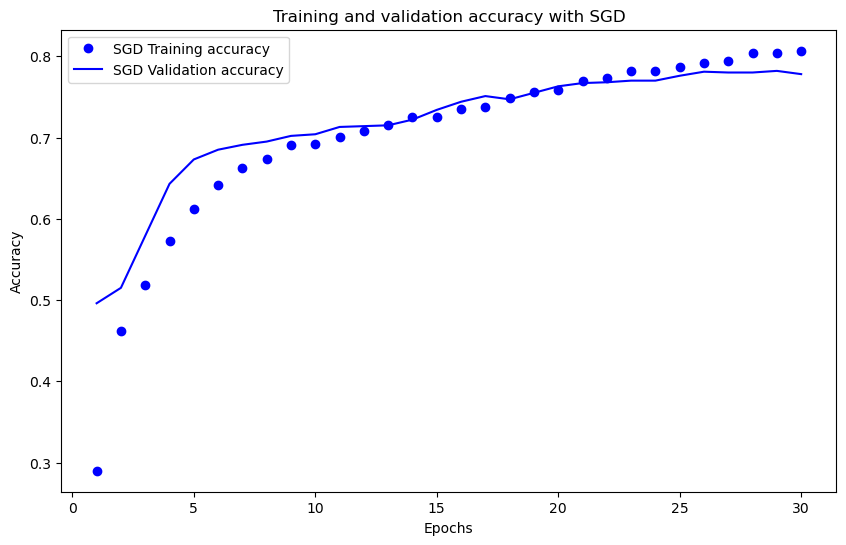

Training with Adagrad optimizer...


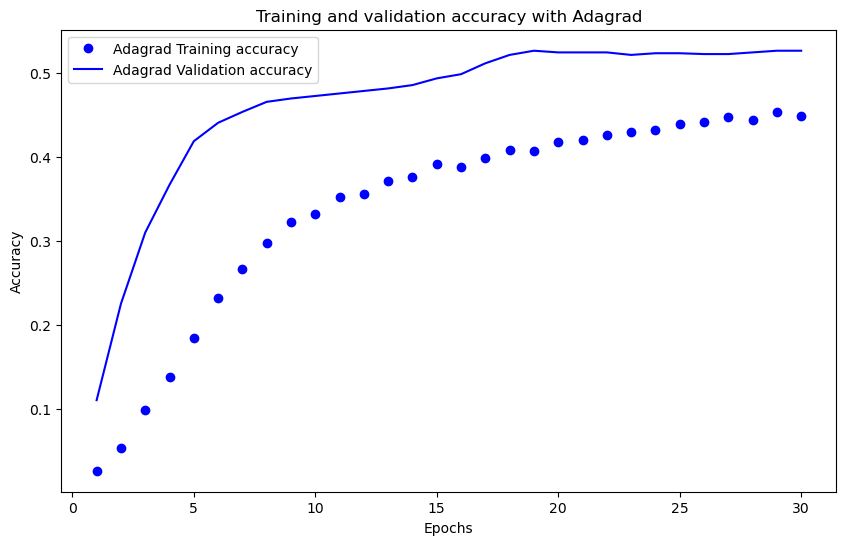

Training with AdaMax optimizer...


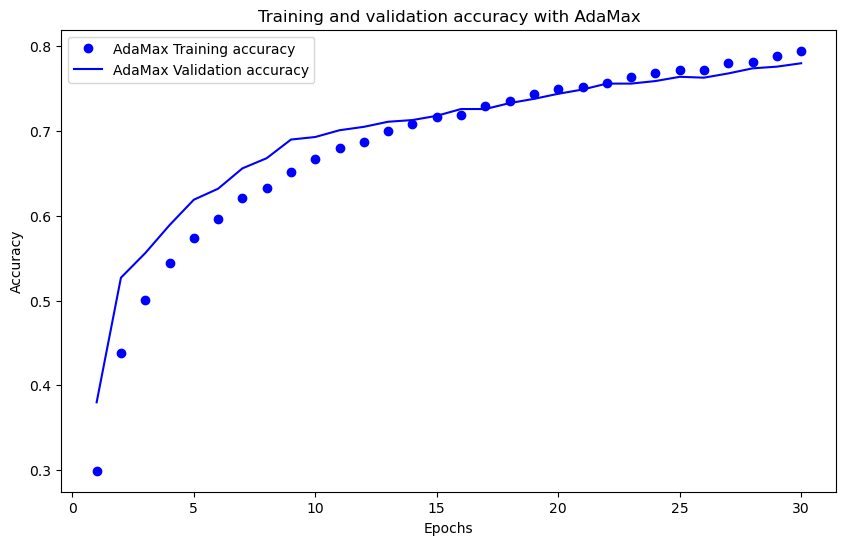

In [349]:
# Train the model with each optimizer and record the best validation accuracy
for opt_name, optimizer in optimizers.items():
    print(f"Training with {opt_name} optimizer...")
    
    # Build and compile the model
    model = build_and_compile_model(optimizer)
    
    # Train the model
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=30,
                        batch_size=256, # Changed to smaller batch size
                        validation_data=(x_val, y_val),
                        verbose=0)
    
    # Extract the best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    
    # Store the best validation accuracy in the results table
    results_table[opt_name] = best_val_acc
    
    # Plot the training and validation accuracy for each optimizer
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(10, 6)) # Create a new figure for each optimizer
    plt.plot(epochs, history.history['accuracy'], 'bo', label=f'{opt_name} Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label=f'{opt_name} Validation accuracy')
    plt.title(f'Training and validation accuracy with {opt_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [350]:
import pandas as pd

# Print the table of results

# Convert the results_table dictionary into a Pandas DataFrame
results_df = pd.DataFrame(list(results_table.items()), columns=['Optimizer', 'Best Validation Accuracy'])

# Display the table
print("Best validation accuracy for each optimizer:")
results_df


Best validation accuracy for each optimizer:


,Optimizer,Best Validation Accuracy
0,RMSprop,0.830
1,Adam,0.826
2,SGD,0.782
3,Adagrad,0.527
4,AdaMax,0.780


In [352]:
# Choose the best optimizer based on validation accuracy
best_optimizer = results_df.loc[results_df['Best Validation Accuracy'].idxmax(), 'Optimizer']
print(f"The best optimizer is: {best_optimizer}")

# Build and train the model again with the best optimizer
best_model = build_and_compile_model(optimizers[best_optimizer])
best_model.fit(partial_x_train,
               partial_y_train,
               epochs=30,
               batch_size=256,
               validation_data=(x_val, y_val),
               verbose=0)

# Evaluate the model on the test data
test_results = best_model.evaluate(x_test, one_hot_test_labels)
print(f"Test accuracy with {best_optimizer}: {test_results[1]}")


The best optimizer is: RMSprop
71/71 [==============================] - 0s 559us/step - loss: 1.3019 - accuracy: 0.7952
Test accuracy with RMSprop: 0.7951914668083191
